In [1]:
%matplotlib inline
import os
import re
import glob
from collections import Counter
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import linear_model

import file_handling as fh

sbn.set(font_scale=1.5)


/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
data_dir = '/Users/dcard/Projects/CMU/ARK/LN_tools/parsed/StanfordMSA/'
spreadsheet_file = '/Users/dcard/Dropbox/CMU/ARK/terrorism/databases/MSA/Data/Stanford_MSA_Database.csv'
output_dir = './data/msa/'

msa_df = pd.read_csv(spreadsheet_file, header=0)

{'Arrested', 'Custody/Escaped', 'Killed', 'Escaped', 'Custody', 'Deceased'}
{nan, 'Arrested', 'Custody / Escaped', 'Custody/Escaped', 'FALSE', 'Escaped', 'Custody', 'Deceased'}
{'Retail/Wholesale/Services facility\n/Residential home/Neighborhood', 'Restaurant/cafe', 'Public Transportation', 'Primary school', 'Restaurant/Cafe?', 'Military facility', 'Secondary school', 'Retail/ Wholesale/Services facility', 'Retail/Wholesale/Services facility', 'Park/Wildness', 'Retail/ Wholesale/Services facility\nand Primary school', 'Entertainment Venue', 'Restaurant/Cafeé', 'Public transportation', 'Government facility', 'College/University/Adult education', 'Residential home/Neighborhood', 'Residential Home/Neighborhood', 'Entertainment venue', 'Place of worship', 'Restaurant/Cafe', 'Residential home', 'Park/Wilderness', 'Residential home/Neighborhood,\nRetail/ Wholesale/Services facility', 'Residential home/Neighborhood \nand Street/Highway', 'Medical/Care', 'Secondary School', 'Unknown', 'Company

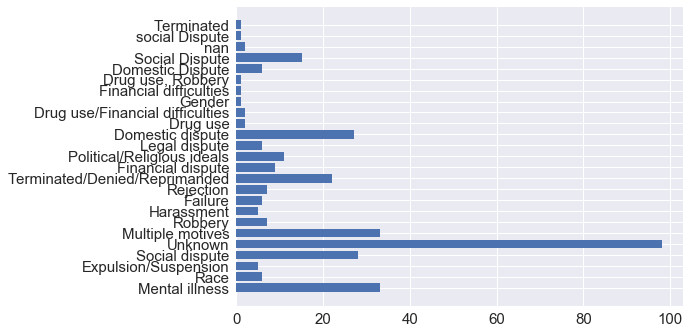

In [3]:
print(set(msa_df['Fate of Shooter at the scene'].values))
print(set(msa_df['Fate of Shooter'].values))
print(set(msa_df['Place Type'].values), len(set(msa_df['Place Type'].values)))
print(set(msa_df['Shooter Sex'].values))
print(set(msa_df['Shooter Race'].values))
print(set(msa_df["Shooter's Cause of Death"].values))
print(set(msa_df["History of Mental Illness - General"].values))
print(set(msa_df["Military Experience"].values))
counts = Counter()
fig, ax = plt.subplots()
counts.update(msa_df["Possible Motive - General"].values)
keys = list(counts.keys())
vals = [counts[k] for k in keys]
ax.barh(np.arange(len(vals)), vals)
ax.set_yticks(np.arange(len(vals)))
ax.set_yticklabels(keys)
plt.show();

In [4]:
msa_descriptions = []
df = pd.DataFrame(columns=['caseid', 'title', 'date', 'year', 'civilian_fatalities', 'enforcement_fatalities', 'n_fatalities', 'n_victims', 'n_articles', 'lat', 'long', 'race', 'name'])
articles = []
articles_by_incident = {}
to_save = []

df_out = pd.DataFrame(columns=['df_index', 'caseid', 'title', 'city', 'n_fatalities', 'n_victims', 'n_shooters', 'name', 'race', 'description', 'article', 'article_name'])
df_out_count = 0

for index in msa_df.index:
    row = msa_df.loc[index]
    caseid = int(row['CaseID'])
    title = row['Title']
    city = row['City']
    state = row['State']
    lat = row['Latitude']
    long = row['Longitude']
    civilian_fatalities = row['Number of Civilian Fatalities']
    civilian_injuries = row['Number of Civilian Injured']
    enforcement_fatalities = row['Number of Enforcement Fatalities']
    enforcement_injuries = row['Number of Enforcement Injured']
    n_fatalities = int(row['Total Number of Fatalities'])
    n_victims = int(row['Total Number of Victims'])
    description = row['Description']
    date = pd.to_datetime(row['Date'])
    year = date.year
    name = row['Shooter Name']
    n_shooters = row['Number of shooters']
    shooter_age = row['Average Shooter Age']
    sex = row['Shooter Sex']
    race = row['Shooter Race']
    n_shotguns = row['Number of Shotguns']
    n_rifles = row['Number of Rifles']
    n_handguns = row['Number of Handguns']
    n_guns = row['Total Number of Guns']
    n_automatic = row['Number of Automatic Guns']
    n_semi = row['Number of Semi-Automatic Guns']
    fate_at_scene = row['Fate of Shooter at the scene']
    fate_of_shooter = row['Fate of Shooter']
    cause_of_death = row["Shooter's Cause of Death"]
    school_related = row['School Related']
    place_type = row['Place Type']
    relationship_to_place = row['Relationship to Incident Location']
    target_details = row['Targeted Victim/s - Detailed']
    target_general = row['Targeted Victim/s - General']
    motive_details = row['Possible Motive - Detailed']
    motive_general = row['Possible Motive - General']
    mental_details = row['History of Mental Illness - Detailed']
    mental_general = row['History of Mental Illness - General']
    military = row['Military Experience']
    event_type = row['Class']   # MS = mass shooting, SPK = spree killing, SEK = serial, GD = gang/drug, FMS = family murder/suicide
    depreciation = row['Depreciation']  # 0 = does not fit criteria; 2 = borderline

    msa_descriptions.append({'id': caseid, 'text': description})
 
    input_dir = os.path.join(data_dir, str(caseid) + '_' + '_'.join(name.split()))
    if os.path.exists(input_dir):        
        n_articles = len(glob.glob(os.path.join(input_dir, 'partition', '1', '1', '*.txt')))
        df.loc[index] = [caseid, title, date, year, civilian_fatalities, enforcement_fatalities, n_fatalities, n_victims, n_articles, lat, long, race, name]
        metadata = fh.read_json(os.path.join(input_dir, 'metadata', 'metadata.json'))
        for article_name in metadata:
            fulldate = metadata[article_name]['fulldate']
            source = metadata[article_name]['source']
            filename = os.path.join(input_dir, 'partition', '1', '1', article_name + '_short.txt')
            if os.path.exists(filename):
                with open(filename, 'r') as f:
                    text = f.read()
                paragraphs = text.split('\n\n')[2:]
                # add a period after headline to help parser
                paragraphs[0] += '.'
                text = '\n'.join(paragraphs)
                article_dict = {'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'eventdate': date, 'race': race}
                articles.append(article_dict)
                to_save.append({'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'name': name})
                if index not in articles_by_incident:
                    articles_by_incident[index] = []
                articles_by_incident[index].append(article_dict)
                df_out.loc[df_out_count] = [index, caseid, title, city, n_fatalities, n_victims, n_shooters, name, race, description, ' '.join(paragraphs), os.path.split(filename)[-1]]
                df_out_count += 1

df['n_articles'] = pd.to_numeric(df['n_articles'])
df['n_victims'] = pd.to_numeric(df['n_victims'])
df['n_fatalities'] = pd.to_numeric(df['n_fatalities'])

print(df.isnull().values.any())

print(len(articles))
fh.write_jsonlist(to_save, os.path.join(output_dir, 'articles.jsonlist'))
df_out.to_csv(os.path.join(output_dir, 'articles.csv'))
df.head()

False
5857


,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name
31,32,GMAC Loan Office,1990-06-17,1990,11,0,12,17,23,30.332161,-81.675770,Black American or African American,James Edward Pough
32,33,University of Iowa,1991-11-01,1991,5,0,6,6,8,41.655894,-91.531180,Asian American,Gang Lu
33,34,Ridgewood Post Office,1991-10-10,1991,3,0,3,3,5,40.982133,-74.112647,Black American or African American,Joseph M. Harris
34,35,"Luby's Cafeteria in Killeen, Texas",1991-10-16,1991,23,0,24,43,25,31.079255,-97.733923,White American or European American,George Hennard
35,36,Royal Oak Post Office,1991-11-14,1991,4,0,5,9,8,42.508402,-83.153874,White American or European American,Thomas McIlvane


In [5]:
name_tokens = set()
names = {}
for i in df.index:
    name = df.loc[i, 'name']
    tokens = name.split()
    tokens = [token for token in tokens if token[0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']
    tokens = [token for token in tokens if '.' not in token]
    tokens = [re.sub(r',', '', token) for token in tokens]
    tokens = [re.sub(r'\?', '', token) for token in tokens]
    tokens = [token for token in tokens if token not in ['Unknown', 'Unkown', 'One', 'Two', 'Jr', 'II', 'III', 'IV']]
    tokens = [token for token in tokens if len(token) > 1]
    names[i] = tokens
    name_tokens.update(tokens)
name_tokens = list(name_tokens)
name_tokens.sort()
print(len(names))

300


In [6]:
df['n_incidents'] = 1
grouped = df.groupby('year')
summed = grouped.aggregate(np.sum)
summed.head()


,n_fatalities,n_victims,n_articles,lat,long,n_incidents
year,,,,,,
1990,12,17,23,30.332161,-81.675770,1
1991,47,70,52,189.797143,-458.622110,5
1992,11,30,39,158.838696,-373.664933,4
1993,29,75,128,357.377798,-883.767755,9
1994,12,42,61,170.501175,-354.924583,4


In [50]:
df.tail(n=3)

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
332,342,"Webster, MN party shooting",2016-06-11,2016,0,0,0,4,4,44.529686,-93.352723,Unknown,Unknown,1
333,343,Orlando Nightclub Massacre,2016-06-12,2016,49,0,50,102,400,28.538335,-81.379236,Some other race,Omar Marteen,1
334,344,Nightclub Disput,2016-06-26,2016,0,0,0,3,3,34.948174,-82.127331,Black American or African American,Jody Ray Thompson,1


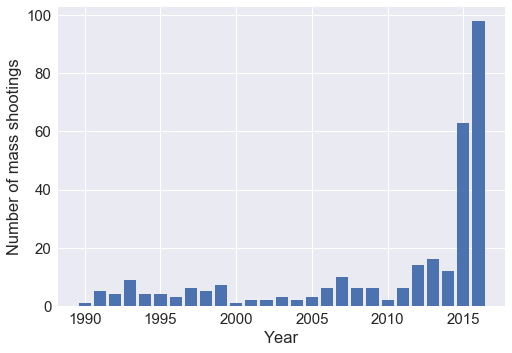

In [40]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_incidents)
ax.set_xlabel('Year')
#ax.set_title('Number of incidents per year');
ax.set_ylabel('Number of mass shootings')
plt.savefig('plots/incidents_per_year.pdf', bbox_inches='tight')


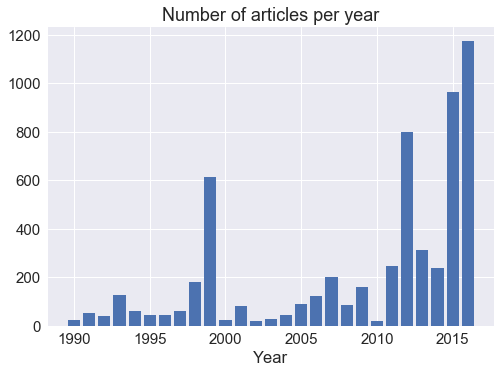

In [8]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles)
ax.set_xlabel('Year')
ax.set_title('Number of articles per year');

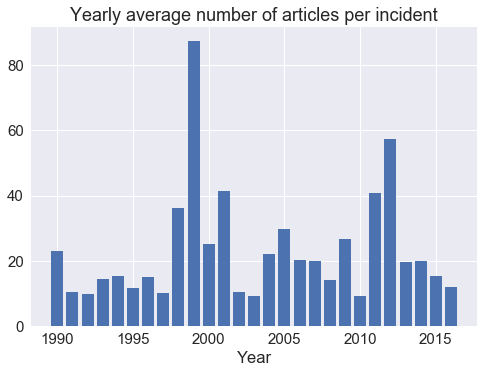

In [9]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of articles per incident');


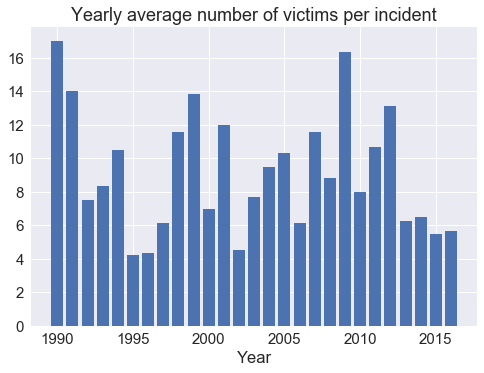

In [10]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_victims / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of victims per incident');


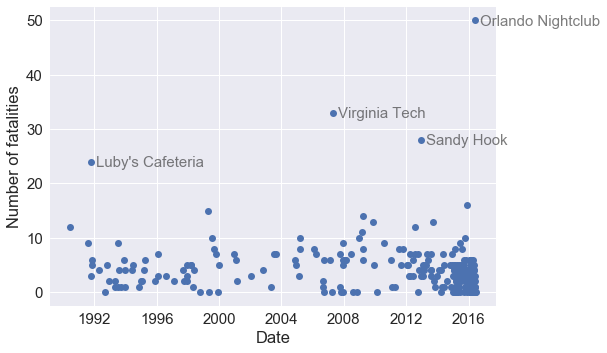

In [41]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_fatalities)
subset = df[df.n_fatalities > 20]
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:2]), xy=(row.date, row.n_fatalities), size=15, xytext=(5, -5), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Number of fatalities');
plt.savefig('plots/fatalities.pdf')

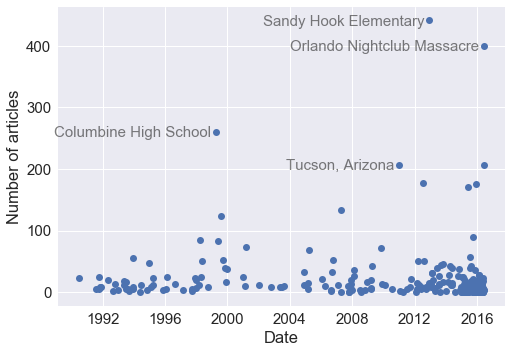

In [49]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_articles)
subset = df[df.n_articles > 206]
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:3]), xy=(row.date, row.n_articles), size=15, xytext=(-5, -5), textcoords='offset points', alpha=0.6, horizontalalignment='right')
ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
#ax.set_title('Number of articles per incident')
plt.savefig('plots/articles_per_event.pdf')

In [13]:
df.sort_values('n_articles', ascending=False).head(n=10)


,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
137,138,Sandy Hook Elementary School,2012-12-14,2012,27,0,28,29,441,41.411908,-73.311963,White American or European American,Adam Lanza,1
333,343,Orlando Nightclub Massacre,2016-06-12,2016,49,0,50,102,400,28.538335,-81.379236,Some other race,Omar Marteen,1
70,71,Columbine High School,1999-04-20,1999,13,0,15,37,260,39.593583,-105.015211,White American or European American,Eric Harris and Dylan Klebold,1
119,120,"Tucson, Arizona",2011-01-08,2011,6,0,6,19,207,32.153589,-110.967765,White American or European American,Jared Lee Loughner,1
331,341,Cape Coral Shooting Spree,2016-06-07,2016,2,0,3,5,206,26.562854,-81.949533,White American or European American,Christopher Michael Moran,1
131,132,Movie Theater in Aurora,2012-07-20,2012,12,0,12,70,177,39.729419,-104.982521,White American or European American,James Eagan Holmes,1
235,245,"San Bernardino, California",2015-12-02,2015,14,0,16,35,175,34.139734,-117.294244,Asian American,Syed Rizwyan Farook\nTashfeen Malik,1
207,215,Mother Emanuel AME Church,2015-06-17,2015,9,0,9,9,171,32.812973,-79.966940,White American or European American,Dylann Storm Roof,1
97,98,Virginia Tech Campus,2007-04-16,2007,32,0,33,49,134,37.229955,-80.427687,Asian American,Seung-Hui Cho,1
72,73,Offices of All-Tech Investment Group and Momen...,1999-07-29,1999,9,0,10,21,123,33.762997,-84.423133,White American or European American,Mark Orrin Barton,1


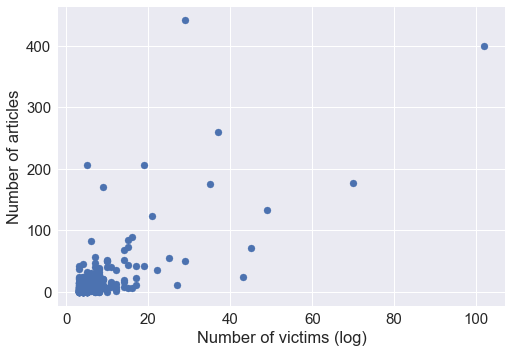

In [14]:
fig, ax = plt.subplots(1, 1)
ax.scatter(np.array(df.n_victims.values, dtype='float'), np.array(df.n_articles.values, dtype='float'))
ax.set_xlabel('Number of victims (log)')
ax.set_ylabel('Number of articles');


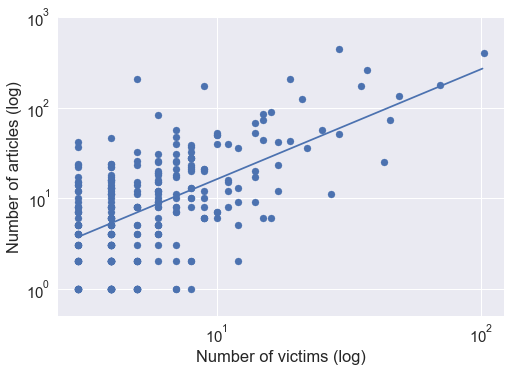

In [15]:
fig, ax = plt.subplots(1, 1)
df_sub = df[df.n_articles > 0]
x = np.array(df_sub.n_victims.values, dtype='float')
y = np.array(df_sub.n_articles.values, dtype='float')
ax.scatter(x, y)
ax.set_xlabel('Number of victims (log)')
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_ylabel('Number of articles (log)');
ax.set_ylim(0.5, 1000)

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(np.log(x).reshape(-1, 1), np.log(y))
x_pred = np.log(np.arange(np.min(x), np.max(x)).reshape(-1, 1))
pred = model.predict(x_pred)
ax.plot(np.exp(x_pred), np.exp(pred))

In [16]:
sources = set([article['source'] for article in articles])
print(sources)

{'san jose mercury news', 'palm beach post', 'tampa bay times', 'atlanta journal and constitution', 'daily news', 'washington post', 'new york times', 'st. petersburg times', 'saint paul pioneer press', 'usa today', 'st. louis post-dispatch', 'philadelphia inquirer'}


In [17]:
event_dates = dict()
articles_per_source = defaultdict(int)
terrorism_mentions_per_source = defaultdict(int)
articles_per_year = defaultdict(int)
terrorism_mentions_per_year = defaultdict(int)
articles_per_event = defaultdict(int)
terrorism_mentions_per_event = defaultdict(int)
articles_per_race = defaultdict(int)
terrorism_mentions_per_race = defaultdict(int)
for article in articles:
    caseid = article['caseid']
    #if caseid != 245 and caseid != 341 and caseid != 343:
    if True:
        source = article['source']
        event_date = article['eventdate']
        race = article['race']
        year = int(str(article['fulldate'])[:4])
        text = article['text'].lower()    
        event_dates[caseid] = event_date
        articles_per_source[source] += 1
        articles_per_event[caseid] += 1
        articles_per_year[year] += 1
        articles_per_race[race] += 1
        if 'terrorism' in text or 'terrorist' in text:
            terrorism_mentions_per_source[source] += 1
            terrorism_mentions_per_event[caseid] += 1
            terrorism_mentions_per_year[year] += 1
            terrorism_mentions_per_race[race] += 1
event_titles = dict(zip(df.caseid.values, df.title.values))


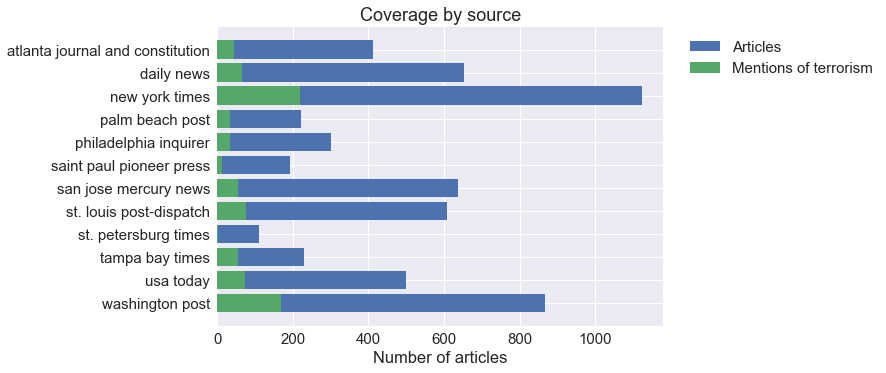

In [18]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_source[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by source')

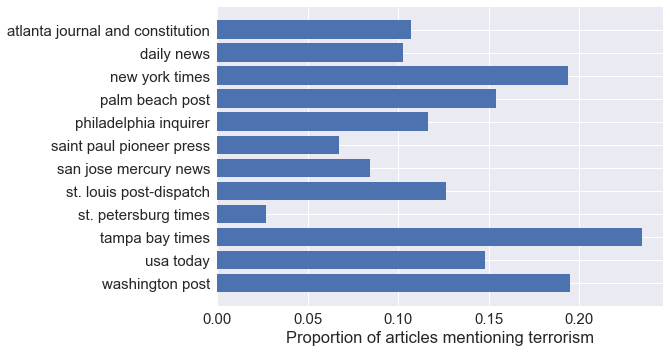

In [19]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k]/articles_per_source[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.set_xlabel('Proportion of articles mentioning terrorism')

245 2015-12-02 00:00:00 San Bernardino, California
341 2016-06-07 00:00:00 Cape Coral Shooting Spree
343 2016-06-12 00:00:00 Orlando Nightclub Massacre


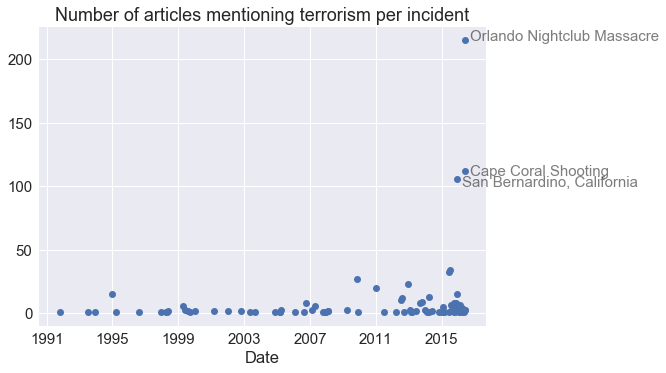

In [20]:
fig, ax = plt.subplots()
#ax.plot_date(list(articles_per_event.keys()), list(articles_per_event.values()))
keys = list(terrorism_mentions_per_event.keys())
dates = [event_dates[caseid] for caseid in keys]
mentions = [terrorism_mentions_per_event[caseid] for caseid in keys]
ax.plot_date(dates, mentions)
count = 0
for caseid in keys:
    if terrorism_mentions_per_event[caseid] > 100:
        count += 1 
        print(caseid, event_dates[caseid], event_titles[caseid])
        ax.annotate(' '.join(event_titles[caseid].split()[:3]), xy=(event_dates[caseid], terrorism_mentions_per_event[caseid]), size=15, xytext=(5, -12 +4*count), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_title('Number of articles mentioning terrorism per incident')

116
158
168
222
240
241
244
245
263
280
341
343


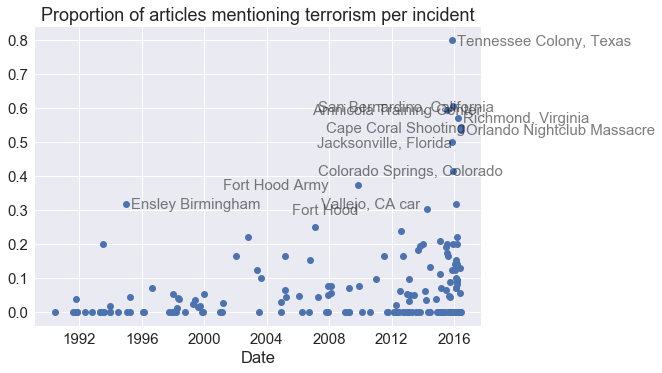

In [21]:
keys = [key for key in articles_per_event.keys() if articles_per_event[key] > 4]
dates = [event_dates[caseid] for caseid in keys]
proportion = [terrorism_mentions_per_event[caseid] / articles_per_event[caseid] for caseid in keys]
fig, ax = plt.subplots()
count = 0
ax.plot_date(dates, proportion)
for caseid in keys:
    year = event_dates[caseid].year
    proportion = terrorism_mentions_per_event[caseid] / articles_per_event[caseid]
    if proportion > 0.3:
        print(caseid)
        count += 1        
        ax.annotate(' '.join(event_titles[caseid].split()[:3]), xy=(event_dates[caseid], proportion), size=15, xytext=(5 -140*((count%3)>0), -5), textcoords='offset points', alpha=0.6)

ax.set_xlabel('Date')
ax.set_title('Proportion of articles mentioning terrorism per incident')

In [22]:
df[df.caseid == 44]

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
43,44,Weber State University,1993-07-08,1993,0,0,1,3,5,41.228137,-111.967532,Asian American,Mark Duong,1


In [23]:
df[df.caseid == 168]

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
168,168,Massachusetts Abortion Clinic,1994-12-30,1994,2,0,2,7,47,42.324274,-71.140800,White American or European American,John Salvi III,1
169,168,Ensley Birmingham,2012-01-29,2012,5,0,5,5,0,33.528287,-86.795504,Black American or African American,"Rashad Stoves, Artavius Underwood, Reginald Mims",1


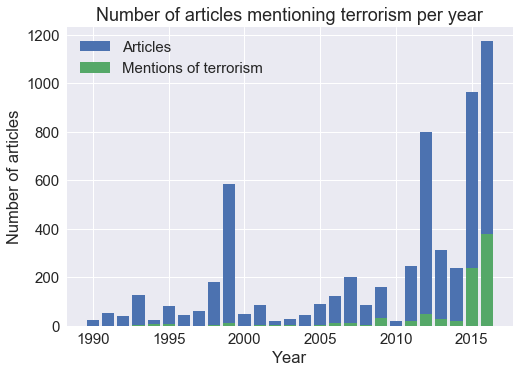

In [24]:
keys = list(articles_per_year.keys())
keys.sort()
fig, ax = plt.subplots()
ax.bar(keys, [articles_per_year[k] for k in keys], label='Articles')
ax.bar(keys, [terrorism_mentions_per_year[k] for k in keys], label='Mentions of terrorism')
ax.set_xlabel('Year')
ax.set_ylabel('Number of articles')
ax.legend()
ax.set_title('Number of articles mentioning terrorism per year')

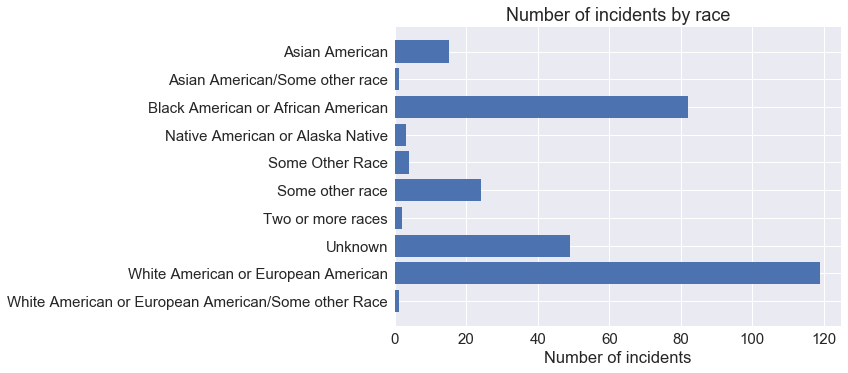

In [25]:
grouped = df.groupby('race')
summed_by_race = grouped.aggregate(np.sum)
summed_by_race.sort_index()
races = list(summed_by_race.index)
fig, ax = plt.subplots()
yticks = list(range(len(races)))
yticks.reverse()
ax.barh(yticks, width=summed_by_race.n_incidents)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of incidents')
ax.set_title('Number of incidents by race');


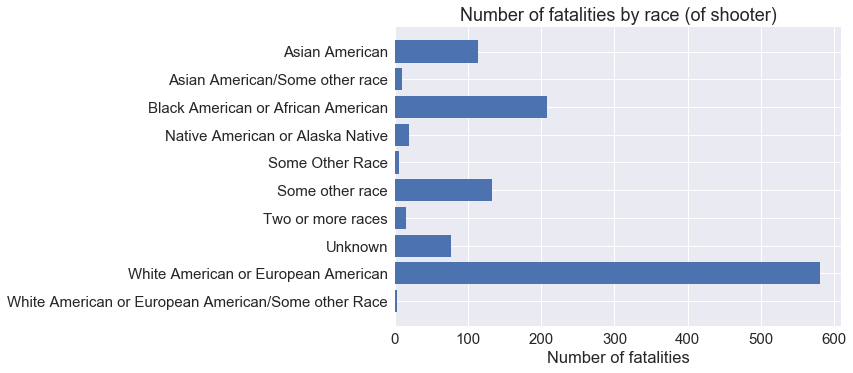

In [26]:
fig, ax = plt.subplots()
ax.barh(yticks, width=summed_by_race.n_fatalities)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of fatalities')
ax.set_title('Number of fatalities by race (of shooter)');

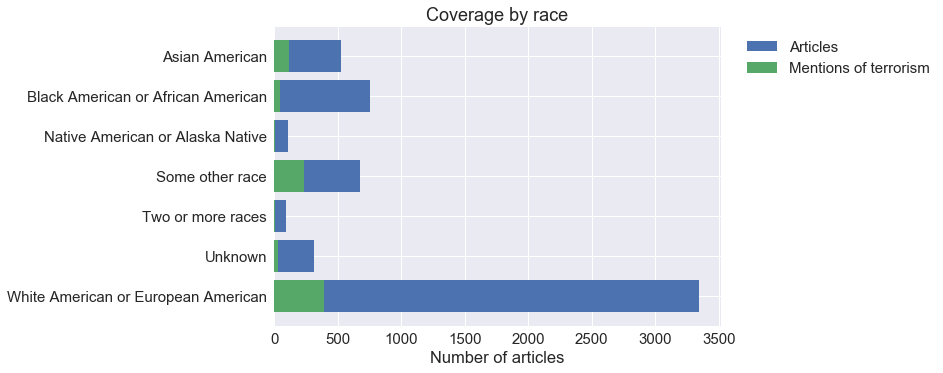

In [27]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_race[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by race');

/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


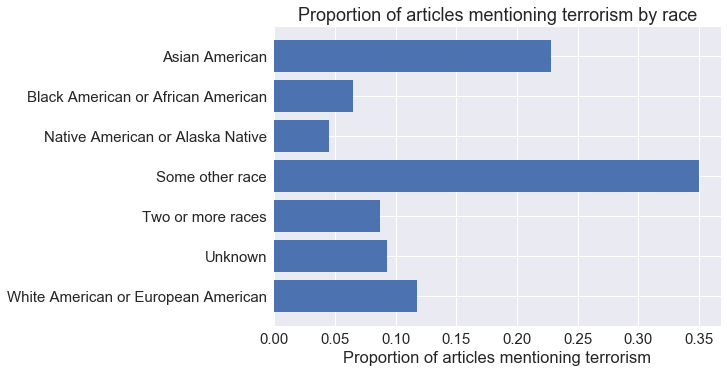

In [28]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] / articles_per_race[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Proportion of articles mentioning terrorism')
ax.set_title('Proportion of articles mentioning terrorism by race');

In [29]:
# Can I make a map in matplotlib? Yes!
from mpl_toolkits.basemap import Basemap
import math

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

scale = 1.0
for i in df.index:
    row = df.loc[i]  
    x, y = map(row.long, row.lat)
    map.plot(x, y, marker='o', color='Blue', markersize=(row['n_fatalities'])*scale, alpha=0.4)
    #map.plot(x, y, marker='o', color='Red', markersize=(row['n_articles'])*scale/10., alpha=0.7)
plt.show();

OSError: cannot locate st99_d00.shp

In [ ]:
counts = []
for article in articles:
    source = article['source']
    event_date = article['eventdate']
    race = article['race']
    year = int(str(article['fulldate'])[:4])
    text = article['text'].lower()    
    terrorism = 0
    if 'terrorism' in text or 'terrorist' in text:
        terrorism = 1
    islam = 0
    if 'islam' in text or 'muslim' in text:
        islam = 1
    mental = 0
    if 'mental' in text:
        mental = 1
    counts.append([terrorism, islam, mental])
n = len(counts)
counts = np.vstack(counts)
sums = counts.sum(axis=0)
df_counts = pd.DataFrame(counts, columns=['terrorism', 'islam', 'mental'])
print(df_counts.mean())
print(df_counts[df_counts.terrorism == 1].mean())
print(df_counts[df_counts.islam == 1].mean())
print(df_counts[df_counts.mental == 1].mean())



In [ ]:
n_sources = len(set(sources))
years = range(df.year.min(), df.year.max()+1)
articles_per_year_by_source = {source: {year: 0 for year in years} for source in sources}
for article in articles:
    source = article['source']
    year = int(str(article['fulldate'])[:4])
    articles_per_year_by_source[source][year] += 1


In [30]:
fig, axes = plt.subplots(n_sources, 1, figsize=(8, 10), sharex=True, sharey=True)
sources = list(sources)
sources.sort()
for i, source in enumerate(sources):
    years = list(articles_per_year_by_source[source].keys())
    counts = [articles_per_year_by_source[source][year] for year in years]
    axes[i].bar(years, counts)
    axes[i].text(2018, 100, source)
    axes[i].set_yticks([100, 200])
    


NameError: name 'n_sources' is not defined

In [39]:
# look at matching names
for i in df_out.index:
    df_index = df_out.loc[i, 'df_index']
    article_text = df_out.loc[i, 'article']
    shooter_names = names[df_index]
    df_out.loc[i, 'shooter_names'] = ' '.join(shooter_names)
    age = msa_df.loc[df_index, 'Average Shooter Age']
    city = msa_df.loc[df_index, 'City']
    prop = 0.0
    for name in shooter_names:
        if name in article_text:
            prop += 1.0 / len(shooter_names)            
    df_out.loc[i, 'prop_names_found'] = prop
    age_string = age + "-year-old"
    if age_string in article_text:
        age_found = True
        df_out.loc[i, 'age_found'] = 1
    else:
        age_found = False
        df_out.loc[i, 'age_found'] = 0

    if city in article_text:
        city_found = True
        df_out.loc[i, 'city_found'] = 1
    else:
        city_found = False
        df_out.loc[i, 'city_found'] = 0
    
    if prop > 0 or age_found or city_found:
        df_out.loc[i, 'matching'] = 1
    else:
        df_out.loc[i, 'matching'] = 0
        
    # zero out Cape Coral!
    
    
    df_out.loc[i, 'age'] = age

n_items, n_columns = df_out.shape
order = np.arange(n_items)
np.random.shuffle(order)
df_out['order'] = order

df_out.to_csv(os.path.join(output_dir, 'articles.csv'))

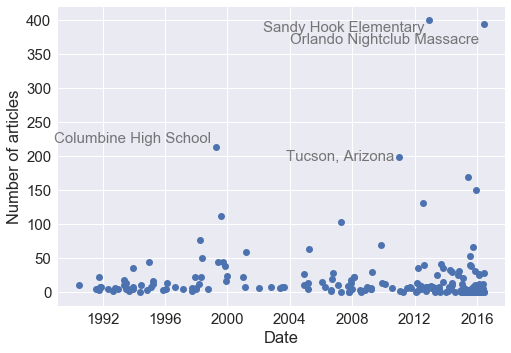

In [61]:
df['n_matching'] = 0
for i in df.index:
    rows = df_out[df_out.df_index == i]
    n_matching = rows['matching'].sum()
    df.loc[i, 'n_matching'] = n_matching

fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_matching)
subset = df[df.n_matching > 185]
count = 0
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:3]), xy=(row.date, row.n_matching), size=15, xytext=(-5, -5-count*8+10), textcoords='offset points', alpha=0.6, horizontalalignment='right')
    count += 1
ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
#ax.set_title('Number of articles per incident')
plt.savefig('plots/articles_per_event.pdf')

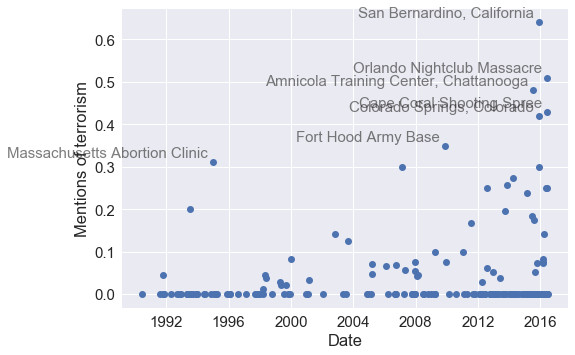

In [79]:
event_dates = dict()
df['terrorism_mentions'] = 0
df['terrorism_prop'] = 0
terrorism_mentions_per_event = defaultdict(int)
for i in df_out.index:
    caseid = df_out.loc[i, 'caseid']
    matching = df_out.loc[i, 'matching']
    if matching:
        if ('terrorism' in df_out.loc[i, 'article'] or 'terrorist' in df_out.loc[i, 'article']) and 'counterterrorism' not in df_out.loc[i, 'article']:
            df_index = df_out.loc[i, 'df_index']
            df.loc[df_index, 'terrorism_mentions'] += 1

for i in df.index:
    if df.loc[i, 'n_matching'] > 3:
        df.loc[i, 'terrorism_prop'] = df.loc[i, 'terrorism_mentions'] / df.loc[i, 'n_matching']

fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.terrorism_prop)
subset = df[df.terrorism_prop > 0.3]
count = 0
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:4]), xy=(row.date, row.terrorism_prop), size=15, xytext=(-5, -5-count*8+10), textcoords='offset points', alpha=0.6, horizontalalignment='right')
    count += 0
ax.set_xlabel('Date')
ax.set_ylabel('Mentions of terrorism');
#ax.set_title('Number of articles per incident')

In [38]:
print(df_out.shape)
df_out.tail(n=3)

(5857, 19)


,df_index,caseid,title,city,n_fatalities,n_victims,n_shooters,name,race,description,article,article_name,shooter_names,prop_names_found,age_found,city_found,matching,age,order
5854,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...","After S.C. killings, families sue over backgro...",344_Jody_Ray_Thompson-7_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,5575
5855,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",The Prosecutors Who Aim to Kill; Editorial. On...,344_Jody_Ray_Thompson-5_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,3979
5856,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",Survivors of Charleston Church Attack Sue F.B....,344_Jody_Ray_Thompson-2_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,4749


In [33]:
age = msa_df.loc[333, 'Average Shooter Age']
print(age)
age_string = age + "-year-old"
text = df_out.loc[5471, 'article']
print(age_string in text)
print(age + "-year-old" in text)


29
True
True


In [34]:
for i in msa_df.index:
    if 'Sandy' in msa_df.loc[i, 'Title']:
        print(i, msa_df.loc[i, 'Description'])
    

137 On December 14, 2012, a 20-year old shot and killed his mother at their home in Newtown, Connecticut. He then travelled to Sandy Hook Elementary School killing twenty children and six adult staff members and injuring two others before killing himself. Court documents showed that the school shooting had occurred in the space of less than five munities with 156 shots fired.


In [35]:
df_out.tail(n=3)

,df_index,caseid,title,city,n_fatalities,n_victims,n_shooters,name,race,description,article,article_name,shooter_names,prop_names_found,age_found,city_found,matching,age,order
5854,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...","After S.C. killings, families sue over backgro...",344_Jody_Ray_Thompson-7_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,1721
5855,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",The Prosecutors Who Aim to Kill; Editorial. On...,344_Jody_Ray_Thompson-5_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,4580
5856,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",Survivors of Charleston Church Attack Sue F.B....,344_Jody_Ray_Thompson-2_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,576


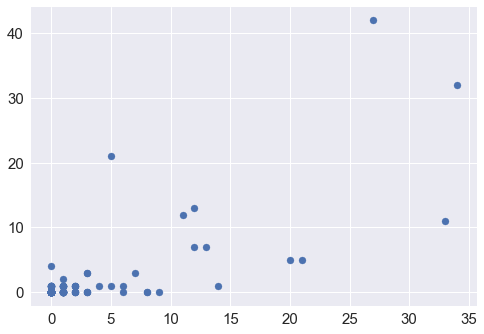

In [36]:
# make a copy of original dataframe
msa_df_copy = pd.DataFrame(msa_df.values, index=msa_df.index, columns=msa_df.columns)
msa_df_copy['n_articles'] = 0
msa_df_copy['terrorism_or_terrorist'] = 0
msa_df_copy['muslim_or_islam'] = 0
msa_df_copy['mental'] = 0

for i in df_out.index:
    row = df_out.loc[i]
    df_index = row['df_index']
    if row['prop_names_found'] > 0 or row['age_found'] or row['city_found']:
        msa_df_copy.loc[df_index, 'n_articles'] += 1
        
        text = row['article'].lower()
        if 'terrorism' in text or 'terrorist' in text:
            msa_df_copy.loc[df_index, 'terrorism_or_terrorist'] += 1
        if 'islam' in text or 'muslim' in text:
            msa_df_copy.loc[df_index, 'muslim_or_islam'] += 1
        if 'mental' in text:
            msa_df_copy.loc[df_index, 'mental'] += 1

temp = msa_df_copy[(msa_df_copy['terrorism_or_terrorist'] < 50)]

plt.scatter(temp['terrorism_or_terrorist'], temp['muslim_or_islam'])